In [1]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

# File Collection

In [3]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        # CHANGEME below is for site A2
        if file_name.endswith('.sta.nc') and not file_name.endswith('.png'):
        
        # CHANGEME below is for site A2
        #if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site C1A
        #if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]


In [6]:
# Usage for BLOC
BLOC_start_date = '20231201'  # Replace with any start date
BLOC_end_date = '20250124'    # Replace with any end date
BLOC_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
BLOC_files = filter_files_by_date(BLOC_directory, BLOC_start_date, BLOC_end_date)

# Usage for Site C1a
C1A_start_date = '20221111'  # Replace with any start date
C1A_end_date = '20231106'    # Replace with any end date
C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'
C1A_files = filter_files_by_date(C1A_directory, C1A_start_date, C1A_end_date)

# Usage for Site A1
A1_start_date = '20231024' 
A1_end_date = '20250504'
A1_files = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteH_Data'


# Wind Veer Function

In [9]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    return diff
    
def calculate_wind_veer(file_paths):
    """
    Calculate wind veer and wind shear from netCDF files, using Azim for wind direction and qc_Azim for quality control.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
    
    Returns:
        tuple: Times (datetime objects), wind veer values, and wind shear values.
    """
    all_times = []
    all_wind_veer = []

    for file_path in file_paths:

        ds = xr.open_dataset(file_path, engine="netcdf4")
        
        # Extract data
        time_var = ds['time']
        if 'sa1' in file_path:
            height_var = ds['distance'].values
            vhm = ds['wind_speed'].values
            qc_vhm = ds['qc_wind_speed'].values
            azim = ds['wind_direction'].values
            qc_azim = ds['qc_wind_direction'].values
        else:
            height_var = ds['height'].values
            vhm = ds['Vhm'].values
            qc_vhm = ds['qc_Vhm'].values
            azim = ds['Azim'].values
            qc_azim = ds['qc_Azim'].values
        
        times = pd.to_datetime(time_var.values, utc=True)

        # Ensure height indices for 40m and 140m are correct
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            print(f"Height levels not found in {height_var}")
            continue
        
        # Calculate wind veer
        wind_direction_40m = azim[:, idx_40m]
        wind_direction_140m = azim[:, idx_140m]

        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        wind_veer = difference / (height_var[idx_140m] - height_var[idx_40m])

        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]

        # Append data
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)

    return all_times, all_wind_veer


# Wind Shear using Power Law

In [12]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)

def calculate_wind_shear_with_alpha(file_paths, start_date=None, end_date=None):
    all_times = []
    all_alpha = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)

        time_var = ds['time']

        if 'sa1' in file_path:
            height_var = ds['distance'].values
            vhm = ds['wind_speed'].values
            qc_vhm = ds['qc_wind_speed'].values
      
        else:
            height_var = ds['height'].values
            vhm = ds['Vhm'].values
            qc_vhm = ds['qc_Vhm'].values
            
        
        
        #print(f"Height variable: {height_var}")
        #print(f"Vhm shape: {vhm.shape}, QC shape: {qc_vhm.shape}")

        times = pd.to_datetime(time_var.values, utc=True)
        
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
        
        idx_40m = np.where(height_var == 40)[0]
        idx_140m = np.where(height_var == 140)[0]
        
        if len(idx_40m) == 0 or len(idx_140m) == 0:
            print(f"Available heights: {height_var}")
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        idx_40m, idx_140m = idx_40m[0], idx_140m[0]
        #print(f"Indices for 40m: {idx_40m}, 140m: {idx_140m}")

        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]
        
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0)
        #print(f"Valid mask has {np.sum(valid_mask)} valid entries")
        
        times = times[valid_mask]
        wind_speed_40m = wind_speed_40m[valid_mask]
        wind_speed_140m = wind_speed_140m[valid_mask]

        if len(times) == 0:
            #print("on file: ", file_path)
            #print("No valid data points after filtering by QC.")
            continue
        
        try:
            alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
        except ValueError as e:
            print(f"Error in alpha calculation: {e}")
            continue

        #print(f"Calculated alpha values: {alpha[:5]} (showing first 5)")
        all_times.extend(times)
        all_alpha.extend(alpha)

    return all_times, all_alpha


# Funcs to Get/Overlay Plots

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def getDailyAvgWindVeer(times, wind_veer, start_date, end_date):
    """
    Returns the daily average wind veer and corresponding times, averaged across all days at each time of day.
    The result is a DataFrame with time of day and the corresponding average wind veer.
    """
    # Check if the lengths of times and wind_veer match
    if not len(times) == len(wind_veer):
        raise ValueError("The lengths of 'times' and 'wind_veer' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')
  
    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer
    })
    
    # Filtering between start and end date
    #df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    
    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
    daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)

    # Print the daily_avg_veer to check if values are being calculated correctly

    # Return a DataFrame containing the time of day and the corresponding daily average veer
    return pd.DataFrame({
        'time_of_day': daily_avg_veer.index,
        'average_wind_veer': daily_avg_veer.values,
        'std' : daily_std_veer.values
    })

# Plotting function to plot multiple dataframes
import matplotlib.cm as cm

def getDailyAvgWindShear(times, wind_shear, start_date, end_date):
    """
    Gets daily average wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, and wind_shear match
    if not (len(times) == len(wind_shear)):
        raise ValueError("The lengths of 'times' and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    #df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages and standard deviations (for error bars)
    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
    daily_std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)


    return pd.DataFrame({
        'time_of_day': daily_avg_shear.index,
        'average_wind_shear': daily_avg_shear.values,
        'std': daily_std_shear.values
    })


def get_color_palette(num_dataframes):
    # Simple 3-color palette for small datasets (high contrast)
    simple_palette = ["#2ca02c","#1f77b4","#ff7f0e"]  # Green, Blue, Orange

    # October to November (Fall to Late Fall)
    oct_nov_palette = [
        "#8B4513",  # October - Deep Brown (Autumn Leaves)
        "#D2691E",  # November - Burnt Orange (Late Fall Foliage)
        "#B8860B",  # December - Goldenrod (Winter transition)
        "#4682B4",  # January - Steel Blue (Cold winter sky)
        "#1E90FF",  # February - Bright Blue (Crisp winter day)
        "#228B22",  # March - Forest Green (Spring begins)
        "#32CD32",  # April - Bright Lime Green (Fresh growth)
        "#66CDAA",  # May - Medium Aquamarine (Spring in full bloom)
        "#FFD700",  # June - Gold (Warm summer light)
        "#FFA500",  # July - Orange (Hot summer sun)
        "#FF4500",  # August - Red-Orange (Late summer warmth)
        "#CD5C5C",  # September - Indian Red (Early fall leaves)
        "#DC143C",  # October - Crimson (Peak fall colors)
        "#A52A2A"   # November - Brown (Fading fall)

        ]

    # December to December (Winter to Winter)
    dec_dec_palette = [
        "#4682B4",  # December - Steel Blue (Cold and wintery)
        "#1E90FF",  # January - Bright Blue (Cold clarity)
        "#87CEEB",  # February - Sky Blue (Crisp winter air)
        "#228B22",  # March - Forest Green (Early spring)
        "#32CD32",  # April - Lime Green (Spring growth)
        "#66CDAA",  # May - Medium Aquamarine (Lush spring)
        "#FFD700",  # June - Gold (Bright summer)
        "#FFA500",  # July - Orange (Hot and sunny)
        "#FF4500",  # August - Red-Orange (Warm summer nights)
        "#CD5C5C",  # September - Indian Red (Autumn transition)
        "#DC143C",  # October - Crimson (Fall peak)
        "#D2691E",  # November - Burnt Orange (Late autumn)
        "#8B4513",  # December - Deep Brown (Winter transition)
        "#4682B4"   # January - Looping back to winter blue
    ]

    if num_dataframes > 3:
        return dec_dec_palette
    elif num_dataframes == 3:
        return simple_palette
    else:
        return simple_palette[:num_dataframes]  # Trim if fewer than 3


def plotMultipleDataFrames(dataframes, labels=None, title="Multiple DataFrame Plot", xlabel="Time of Day", ylabel="Average Wind Veer (deg/m)"):
    """
    Plots multiple dataframes on the same plot.
    Each dataframe should contain 'time_of_day' and 'average_wind_veer' columns.
    Adds a vertical line indicating the time at which the maximum wind veer happens.
    """
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    vertical_lines_x = set()

    # Define a list of colors (you can extend this list if needed)
    colors = get_color_palette(len(dataframes))

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

    # Loop through each dataframe and plot it
    for idx, df in enumerate(dataframes):
        # Check that 'time_of_day' and 'average_wind_veer' columns exist
        if 'time_of_day' not in df and 'average_wind_veer' and 'average_wind_shear' not in df:
            print(f"DataFrame {idx} is missing required columns.")
            continue

        # If labels are provided, use them, otherwise use the index
        label = labels[idx] if labels is not None else f"Dataset {idx+1}"

        # Get the color from the color palette
        line_color = colors[idx]

        # Plot the data
        if 'average_wind_veer' in df:
            plot_line, = ax.plot(df['time_of_day'], df['average_wind_veer'], label=label, marker='o', color=line_color)
            
            # Find the time at which the maximum veer occurs
            max_veer_idx = df['average_wind_veer'].idxmax()
            max_veer_time = df['time_of_day'][max_veer_idx]
            ax.errorbar(df['time_of_day'], df['average_wind_veer'], yerr=df['std'], marker='o', color=line_color, capsize=3)
            ax.axvline(x=max_veer_time, 
                       color=line_color, 
                       linestyle='--', 
                       label=f"Max Veer in {label} of {df['average_wind_veer'][max_veer_idx]:.2g} deg/m at {max_veer_time}")
        else:
            plot_line, = ax.plot(df['time_of_day'], df['average_wind_shear'], label=label, marker='o', color=line_color)
            
            # Find the time at which the maximum veer occurs
            max_shear_idx = df['average_wind_shear'].idxmax()
            max_shear_time = df['time_of_day'][max_shear_idx]
            ax.errorbar(df['time_of_day'], df['average_wind_shear'], yerr=df['std'], marker='o', color=line_color, capsize=3)
            ax.axvline(x=max_shear_time, 
                       color=line_color, 
                       linestyle='--', 
                       label=f"Max Shear in {label} of {df['average_wind_shear'][max_shear_idx]:.2g} m/sm at {max_shear_time}")

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)

    # Add legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()


# Wind Veer C1A and BLOC Layered

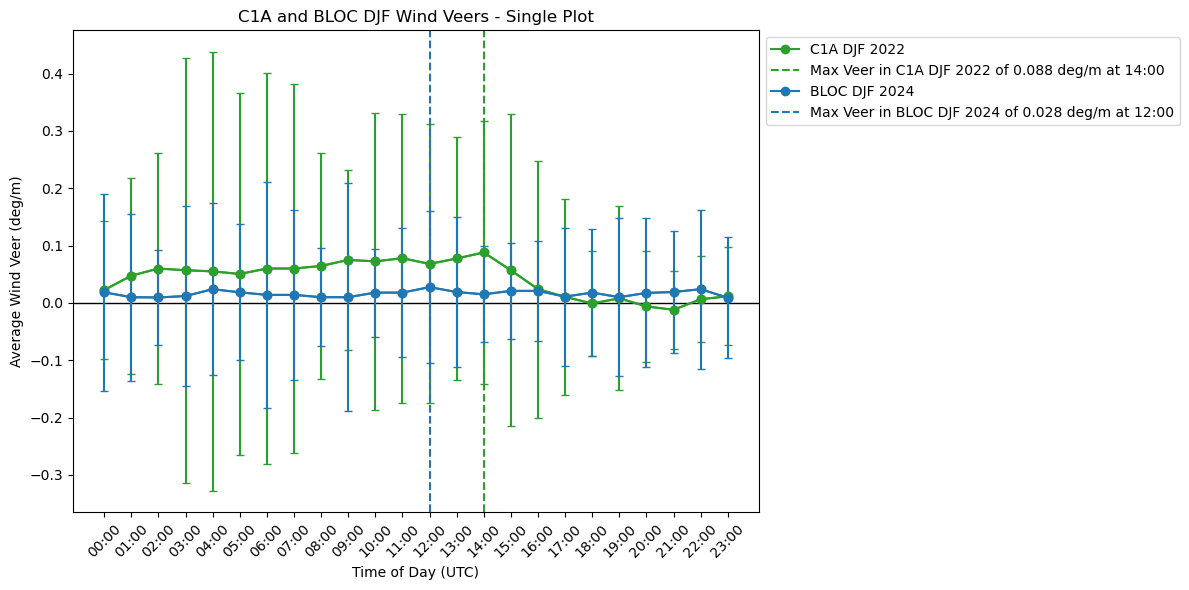

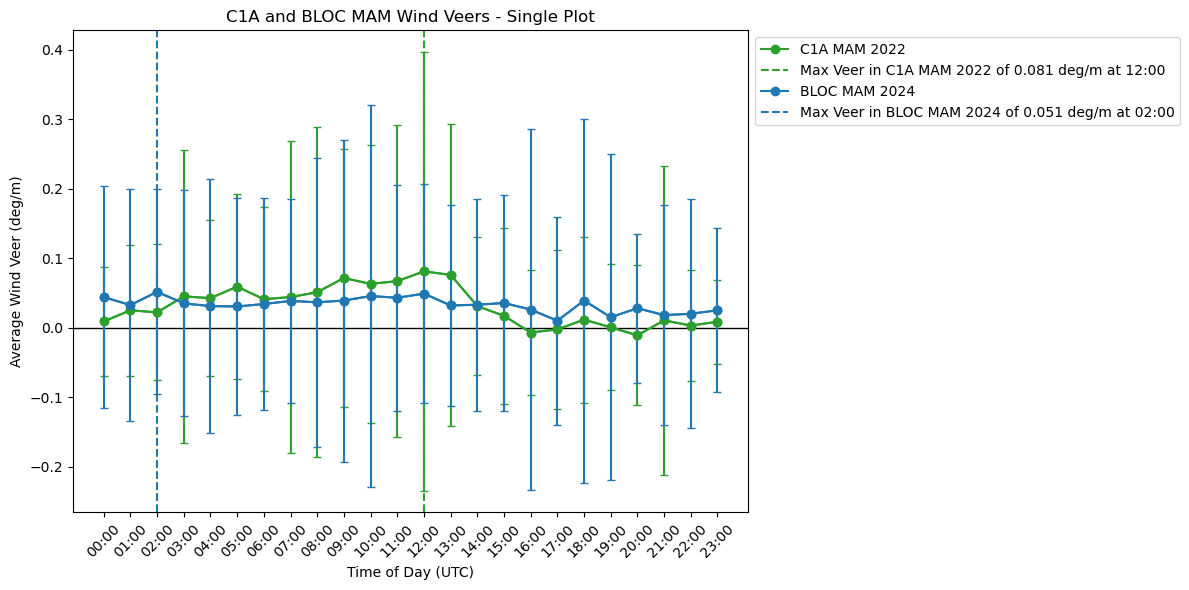

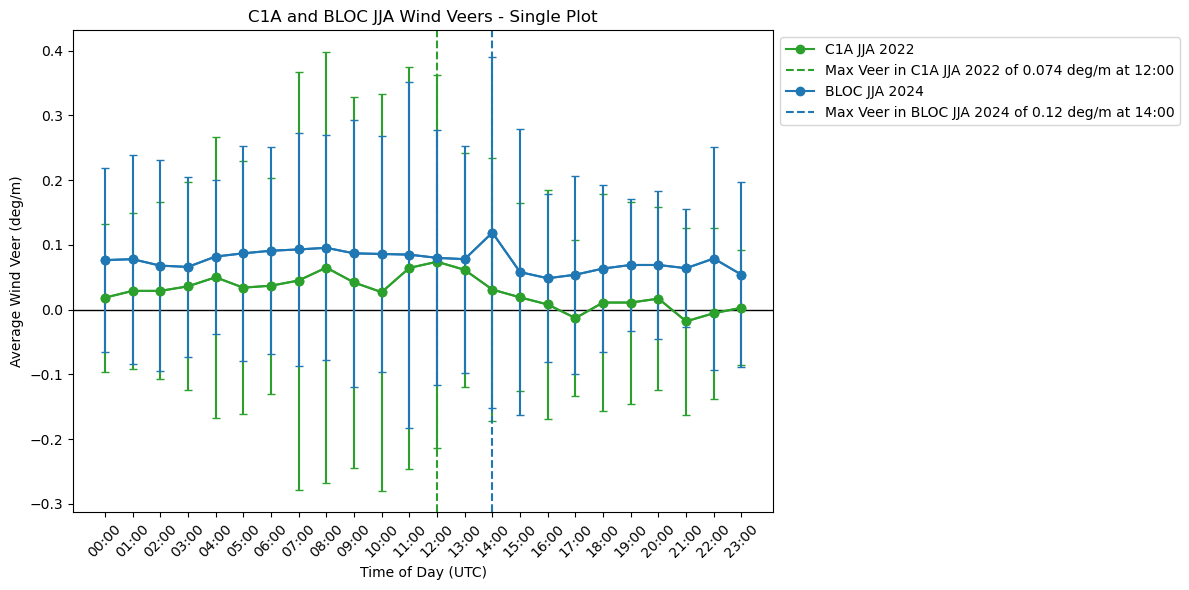

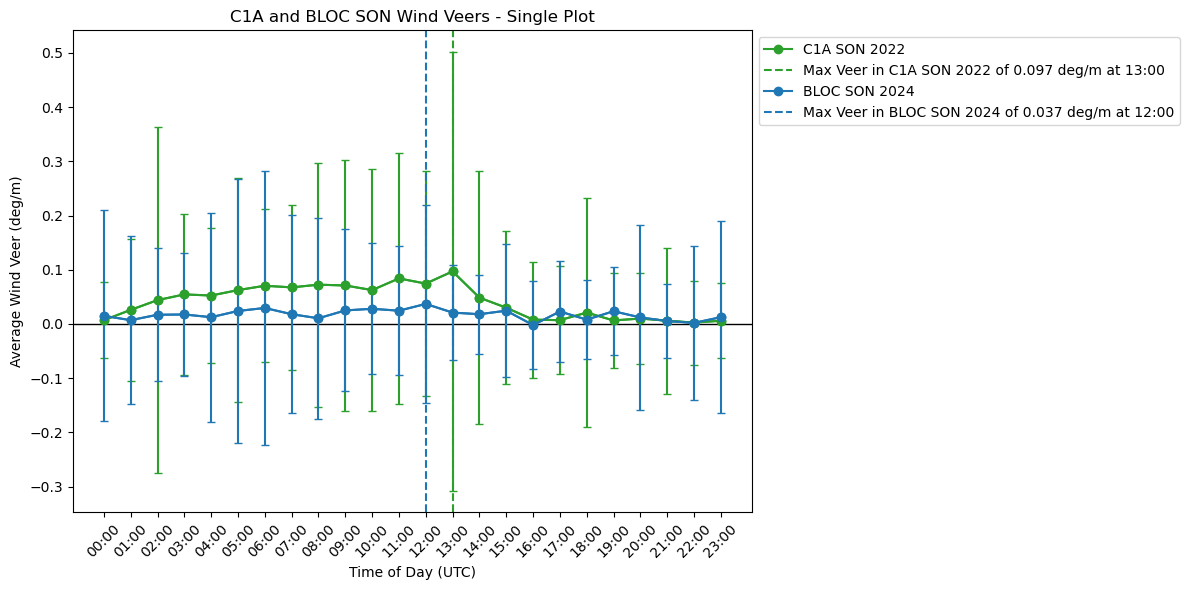

In [18]:
C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'
BLOC_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'  # Update with the correct directory for BLOC data

'''
# Hardcoded function calls for each month with correct date ranges
C1A_202210_files = filter_files_by_date(C1A_directory, '20221001', '20221031')
C1A_times_veer_202210, C1A_wind_veer_202210 = calculate_wind_veer(C1A_202210_files)
C1A_avg_202210 = getDailyAvgWindVeer(C1A_times_veer_202210, C1A_wind_veer_202210, pd.to_datetime('2022-10-01'), pd.to_datetime('2022-10-31'))

C1A_202211_files = filter_files_by_date(C1A_directory, '20221101', '20221130')
C1A_times_veer_202211, C1A_wind_veer_202211 = calculate_wind_veer(C1A_202211_files)
C1A_avg_202211 = getDailyAvgWindVeer(C1A_times_veer_202211, C1A_wind_veer_202211, pd.to_datetime('2022-11-01'), pd.to_datetime('2022-11-30'))
'''
#DJF 
C1A_DJF23_files = filter_files_by_date(C1A_directory, '20221201', '20230228')
C1A_times_veer_DJF23, C1A_wind_veer_DJF23 = calculate_wind_veer(C1A_DJF23_files)
C1A_avg_DJF23 = getDailyAvgWindVeer(C1A_times_veer_DJF23, C1A_wind_veer_DJF23, pd.to_datetime('2022-12-01'), pd.to_datetime('2023-02-28'))

BLOC_DJF24_files = filter_files_by_date(BLOC_directory, '20231201', '20240228')
BLOC_times_veer_DJF24,BLOC_wind_veer_DJF24 = calculate_wind_veer(BLOC_DJF24_files)
BLOC_avg_DJF24 = getDailyAvgWindVeer(BLOC_times_veer_DJF24, BLOC_wind_veer_DJF24, pd.to_datetime('2023-12-01'), pd.to_datetime('2024-02-28'))

#MAM
C1A_MAM23_files = filter_files_by_date(C1A_directory, '20230301','20230531')
C1A_times_veer_MAM23, C1A_wind_veer_MAM23 = calculate_wind_veer(C1A_MAM23_files)
C1A_avg_MAM23 = getDailyAvgWindVeer(C1A_times_veer_MAM23, C1A_wind_veer_MAM23, pd.to_datetime('2023-03-01'), pd.to_datetime('2023-05-31'))

BLOC_MAM24_files = filter_files_by_date(BLOC_directory, '20240301','20240531')
BLOC_times_veer_MAM24, BLOC_wind_veer_MAM24 = calculate_wind_veer(BLOC_MAM24_files)
BLOC_avg_MAM24 = getDailyAvgWindVeer(BLOC_times_veer_MAM24, BLOC_wind_veer_MAM24, pd.to_datetime('2024-03-01'), pd.to_datetime('2024-05-31'))

#JJA
C1A_JJA23_files = filter_files_by_date(C1A_directory, '20230601', '20230831')
C1A_times_veer_JJA23, C1A_wind_veer_JJA23 = calculate_wind_veer(C1A_JJA23_files)
C1A_avg_JJA23 = getDailyAvgWindVeer(C1A_times_veer_JJA23, C1A_wind_veer_JJA23, pd.to_datetime('2023-06-01'), pd.to_datetime('2023-08-31'))

BLOC_JJA24_files = filter_files_by_date(BLOC_directory, '20240601', '20240831')
BLOC_times_veer_JJA24, BLOC_wind_veer_JJA24 = calculate_wind_veer(BLOC_JJA24_files)
BLOC_avg_JJA24 = getDailyAvgWindVeer(BLOC_times_veer_JJA24, BLOC_wind_veer_JJA24, pd.to_datetime('2024-06-01'), pd.to_datetime('2024-08-31'))

#SON
C1A_SON23_files = filter_files_by_date(C1A_directory, '20230901', '20231130')
C1A_times_veer_SON23, C1A_wind_veer_SON23 = calculate_wind_veer(C1A_SON23_files)
C1A_avg_SON23 = getDailyAvgWindVeer(C1A_times_veer_SON23, C1A_wind_veer_SON23, pd.to_datetime('2023-09-01'), pd.to_datetime('2023-11-30'))

BLOC_SON24_files = filter_files_by_date(BLOC_directory, '20240901', '20241130')
BLOC_times_veer_SON24, BLOC_wind_veer_SON24 = calculate_wind_veer(BLOC_SON24_files)
BLOC_avg_SON24 = getDailyAvgWindVeer(BLOC_times_veer_SON24, BLOC_wind_veer_SON24, pd.to_datetime('2024-09-01'), pd.to_datetime('2024-11-30'))

plotMultipleDataFrames([C1A_avg_DJF23, BLOC_avg_DJF24], labels=['C1A DJF 2022', 'BLOC DJF 2024'], title="C1A and BLOC DJF Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_MAM23, BLOC_avg_MAM24], labels=['C1A MAM 2022', 'BLOC MAM 2024'], title="C1A and BLOC MAM Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_JJA23, BLOC_avg_JJA24], labels=['C1A JJA 2022', 'BLOC JJA 2024'], title="C1A and BLOC JJA Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_SON23, BLOC_avg_SON24], labels=['C1A SON 2022', 'BLOC SON 2024'], title="C1A and BLOC SON Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")


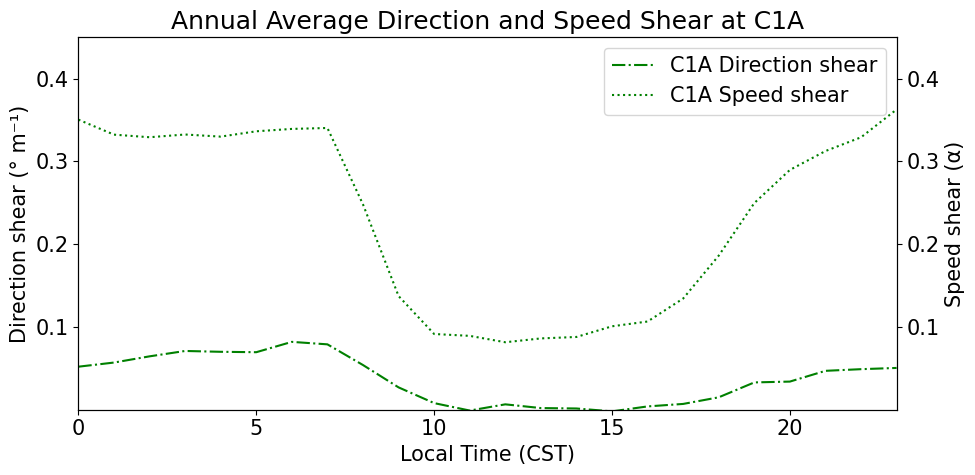

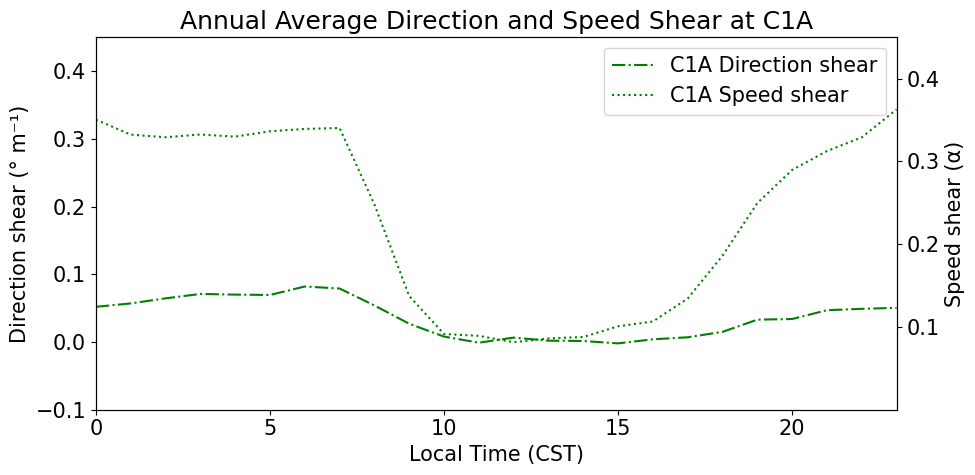

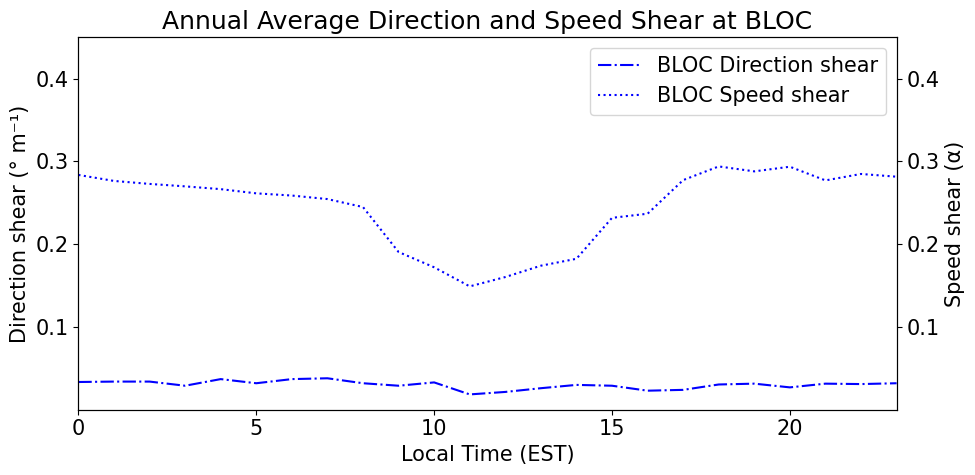

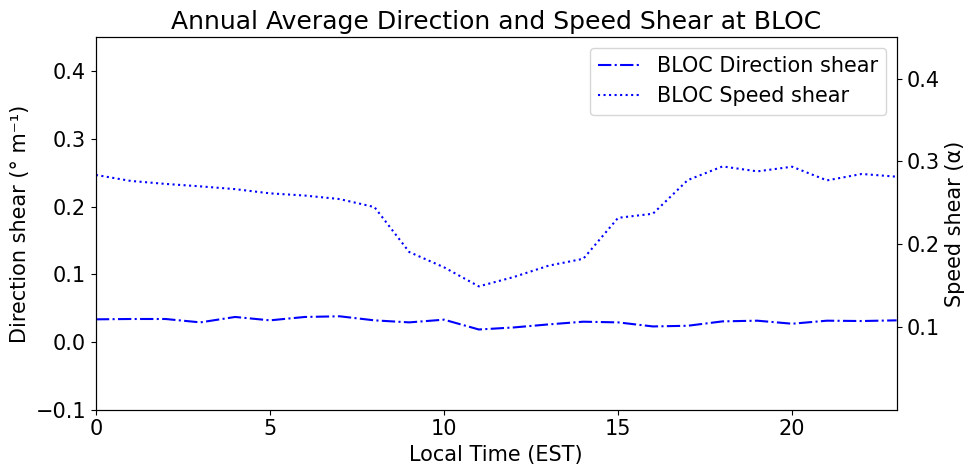

In [76]:
C1A_annual_files = filter_files_by_date(C1A_directory, '20220828', '20230828')
BLOC_annual_files = filter_files_by_date(BLOC_directory, '20240101', '20241231')

C1A_annual_times, C1A_annual_wind_veer = calculate_wind_veer(C1A_annual_files)
C1A_avg_veer = getDailyAvgWindVeer(C1A_annual_times, C1A_annual_wind_veer, pd.to_datetime('2022-08-28'), pd.to_datetime('2023-08-28'))

C1A_annual_times, C1A_annual_wind_shear = calculate_wind_shear_with_alpha(C1A_annual_files)
C1A_avg_shear = getDailyAvgWindShear(C1A_annual_times, C1A_annual_wind_shear, pd.to_datetime('2022-08-28'), pd.to_datetime('2023-08-28'))

BLOC_annual_times, BLOC_annual_wind_veer = calculate_wind_veer(BLOC_annual_files)
BLOC_avg_veer = getDailyAvgWindVeer(BLOC_annual_times, BLOC_annual_wind_veer, pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-31'))

BLOC_annual_times, BLOC_annual_wind_shear = calculate_wind_shear_with_alpha(BLOC_annual_files)
BLOC_avg_shear = getDailyAvgWindShear(BLOC_annual_times, BLOC_annual_wind_shear, pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-31'))


# Extract average values from each dataframe
bloc_veer = BLOC_avg_veer["average_wind_veer"].values
bloc_shear = BLOC_avg_shear["average_wind_shear"].values
c1a_veer = C1A_avg_veer["average_wind_veer"].values
c1a_shear = C1A_avg_shear["average_wind_shear"].values

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({'font.size': 15})  # Default is ~10, so this doubles it

# Time in UTC: 0–23 hours
hours = np.arange(24)

# Convert UTC to local time and sort
c1a_local_hours = (hours - 6) % 24
c1a_sort_idx = np.argsort(c1a_local_hours)
c1a_local_hours = c1a_local_hours[c1a_sort_idx]

bloc_local_hours = (hours - 5) % 24
bloc_sort_idx = np.argsort(bloc_local_hours)
bloc_local_hours = bloc_local_hours[bloc_sort_idx]

# Extract and sort values
c1a_veer = C1A_avg_veer["average_wind_veer"].values[c1a_sort_idx]
c1a_shear = C1A_avg_shear["average_wind_shear"].values[c1a_sort_idx]
bloc_veer = BLOC_avg_veer["average_wind_veer"].values[bloc_sort_idx]
bloc_shear = BLOC_avg_shear["average_wind_shear"].values[bloc_sort_idx]

# ==== C1A PLOT ====
fig, ax1 = plt.subplots(figsize=(10, 5))

# Direction shear (green dash-dot)
ax1.plot(c1a_local_hours, c1a_veer, 'g-.', label='C1A Direction shear')
ax1.set_xlabel('Local Time (CST)')
ax1.set_ylabel('Direction shear (° m⁻¹)')
ax1.set_xlim(0, 23)
ax1.set_ylim(0, 0.45)
ax1.set_yticks([0.1, 0.2, 0.3, 0.4])
ax1.set_xticks([0, 5, 10, 15, 20])
ax1.grid(False)

# Speed shear (green dotted)
ax2 = ax1.twinx()
ax2.plot(c1a_local_hours, c1a_shear, 'g:', label='C1A Speed shear')
ax2.set_ylabel('Speed shear (α)')
ax2.set_ylim(0, 0.45)
ax2.set_yticks([0.1, 0.2, 0.3, 0.4])

# Legend (only C1A)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2
order = ['C1A Direction shear', 'C1A Speed shear']
ordered = sorted(zip(all_labels, all_handles), key=lambda x: order.index(x[0]))
ordered_labels, ordered_handles = zip(*ordered)
ax1.legend(ordered_handles, ordered_labels, loc='upper right')

plt.title('Annual Average Direction and Speed Shear at C1A')
plt.tight_layout()
plt.savefig("C1A_wind_annual.png", dpi=300, bbox_inches='tight')
plt.show()

# ==== C1A PLOT ====
fig, ax1 = plt.subplots(figsize=(10, 5))

# Direction shear (green dash-dot)
ax1.plot(c1a_local_hours, c1a_veer, 'g-.', label='C1A Direction shear')
ax1.set_xlabel('Local Time (CST)')
ax1.set_ylabel('Direction shear (° m⁻¹)')
ax1.set_xlim(0, 23)
ax1.set_ylim(-0.1, 0.45)
ax1.set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax1.set_xticks([0, 5, 10, 15, 20])
ax1.grid(False)

# Speed shear (green dotted)
ax2 = ax1.twinx()
ax2.plot(c1a_local_hours, c1a_shear, 'g:', label='C1A Speed shear')
ax2.set_ylabel('Speed shear (α)')
ax2.set_ylim(0, 0.45)
ax2.set_yticks([0.1, 0.2, 0.3, 0.4])

# Legend (only C1A)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2
order = ['C1A Direction shear', 'C1A Speed shear']
ordered = sorted(zip(all_labels, all_handles), key=lambda x: order.index(x[0]))
ordered_labels, ordered_handles = zip(*ordered)
ax1.legend(ordered_handles, ordered_labels, loc='upper right')

plt.title('Annual Average Direction and Speed Shear at C1A')
plt.tight_layout()
plt.savefig("C1A_wind_annual_neg.png", dpi=300, bbox_inches='tight')
plt.show()

# ==== BLOC PLOT ====
fig, ax1 = plt.subplots(figsize=(10, 5))

# Direction shear (blue dash-dot)
ax1.plot(bloc_local_hours, bloc_veer, 'b-.', label='BLOC Direction shear')
ax1.set_xlabel('Local Time (EST)')
ax1.set_ylabel('Direction shear (° m⁻¹)')
ax1.set_xlim(0, 23)
ax1.set_ylim(0, 0.45)
ax1.set_yticks([0.1, 0.2, 0.3, 0.4])
ax1.set_xticks([0, 5, 10, 15, 20])
ax1.grid(False)

# Speed shear (blue dotted)
ax2 = ax1.twinx()
ax2.plot(bloc_local_hours, bloc_shear, 'b:', label='BLOC Speed shear')
ax2.set_ylabel('Speed shear (α)')
ax2.set_ylim(0, 0.45)
ax2.set_yticks([0.1, 0.2, 0.3, 0.4])

# Legend (only BLOC)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2
order = ['BLOC Direction shear', 'BLOC Speed shear']
ordered = sorted(zip(all_labels, all_handles), key=lambda x: order.index(x[0]))
ordered_labels, ordered_handles = zip(*ordered)
ax1.legend(ordered_handles, ordered_labels, loc='upper right')

plt.title('Annual Average Direction and Speed Shear at BLOC')
plt.tight_layout()
plt.savefig("BLOC_wind_annual.png", dpi=300, bbox_inches='tight')
plt.show()

# ==== BLOC PLOT ====
fig, ax1 = plt.subplots(figsize=(10, 5))

# Direction shear (blue dash-dot)
ax1.plot(bloc_local_hours, bloc_veer, 'b-.', label='BLOC Direction shear')
ax1.set_xlabel('Local Time (EST)')
ax1.set_ylabel('Direction shear (° m⁻¹)')
ax1.set_xlim(0, 23)
ax1.set_ylim(-0.1, 0.45)
ax1.set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax1.set_xticks([0, 5, 10, 15, 20])
ax1.grid(False)

# Speed shear (blue dotted)
ax2 = ax1.twinx()
ax2.plot(bloc_local_hours, bloc_shear, 'b:', label='BLOC Speed shear')
ax2.set_ylabel('Speed shear (α)')
ax2.set_ylim(0, 0.45)
ax2.set_yticks([0.1, 0.2, 0.3, 0.4])

# Legend (only BLOC)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2
order = ['BLOC Direction shear', 'BLOC Speed shear']
ordered = sorted(zip(all_labels, all_handles), key=lambda x: order.index(x[0]))
ordered_labels, ordered_handles = zip(*ordered)
ax1.legend(ordered_handles, ordered_labels, loc='upper right')

plt.title('Annual Average Direction and Speed Shear at BLOC')
plt.tight_layout()
plt.savefig("BLOC_wind_annual_neg.png", dpi=300, bbox_inches='tight')
plt.show()

# Wind Shear C1A and BLOC Layered

In [ ]:
'''
# Hardcoded function calls for each month with correct date ranges
C1A_202210_files = filter_files_by_date(C1A_directory, '20221001', '20221031')
C1A_times_shear_202210, C1A_wind_shear_202210 = calculate_wind_shear(C1A_202210_files)
C1A_avg_202210 = getDailyAvgWindShear(C1A_times_shear_202210, C1A_wind_shear_202210, pd.to_datetime('2022-10-01'), pd.to_datetime('2022-10-31'))

C1A_202211_files = filter_files_by_date(C1A_directory, '20221101', '20221130')
C1A_times_shear_202211, C1A_wind_shear_202211 = calculate_wind_shear(C1A_202211_files)
C1A_avg_202211 = getDailyAvgWindShear(C1A_times_shear_202211, C1A_wind_shear_202211, pd.to_datetime('2022-11-01'), pd.to_datetime('2022-11-30'))
'''
#DJF 
C1A_times_shear_DJF23, C1A_wind_shear_DJF23 = calculate_wind_shear_with_alpha(C1A_DJF23_files)
C1A_avg_DJF23 = getDailyAvgWindShear(C1A_times_shear_DJF23, C1A_wind_shear_DJF23, pd.to_datetime('2022-12-01'), pd.to_datetime('2023-02-28'))

BLOC_times_shear_DJF24,BLOC_wind_shear_DJF24 = calculate_wind_shear_with_alpha(BLOC_DJF24_files)
BLOC_avg_DJF24 = getDailyAvgWindShear(BLOC_times_shear_DJF24, BLOC_wind_shear_DJF24, pd.to_datetime('2023-12-01'), pd.to_datetime('2024-02-28'))

#MAM
C1A_times_shear_MAM23, C1A_wind_shear_MAM23 = calculate_wind_shear_with_alpha(C1A_MAM23_files)
C1A_avg_MAM23 = getDailyAvgWindShear(C1A_times_shear_MAM23, C1A_wind_shear_MAM23, pd.to_datetime('2023-03-01'), pd.to_datetime('2023-05-31'))

BLOC_times_shear_MAM24, BLOC_wind_shear_MAM24 = calculate_wind_shear_with_alpha(BLOC_MAM24_files)
BLOC_avg_MAM24 = getDailyAvgWindShear(BLOC_times_shear_MAM24, BLOC_wind_shear_MAM24, pd.to_datetime('2024-03-01'), pd.to_datetime('2024-05-31'))

#JJA
C1A_times_shear_JJA23, C1A_wind_shear_JJA23 = calculate_wind_shear_with_alpha(C1A_JJA23_files)
C1A_avg_JJA23 = getDailyAvgWindShear(C1A_times_shear_JJA23, C1A_wind_shear_JJA23, pd.to_datetime('2023-06-01'), pd.to_datetime('2023-08-31'))

BLOC_times_shear_JJA24, BLOC_wind_shear_JJA24 = calculate_wind_shear_with_alpha(BLOC_JJA24_files)
BLOC_avg_JJA24 = getDailyAvgWindShear(BLOC_times_shear_JJA24, BLOC_wind_shear_JJA24, pd.to_datetime('2024-06-01'), pd.to_datetime('2024-08-31'))

#SON
C1A_times_shear_SON23, C1A_wind_shear_SON23 = calculate_wind_shear_with_alpha(C1A_SON23_files)
C1A_avg_SON23 = getDailyAvgWindShear(C1A_times_shear_SON23, C1A_wind_shear_SON23, pd.to_datetime('2023-09-01'), pd.to_datetime('2023-11-30'))

BLOC_times_shear_SON24, BLOC_wind_shear_SON24 = calculate_wind_shear_with_alpha(BLOC_SON24_files)
BLOC_avg_SON24 = getDailyAvgWindShear(BLOC_times_shear_SON24, BLOC_wind_shear_SON24, pd.to_datetime('2024-09-01'), pd.to_datetime('2024-11-30'))

plotMultipleDataFrames([C1A_avg_DJF23, BLOC_avg_DJF24], labels=['C1A DJF 2022', 'BLOC DJF 2024'], title="C1A and BLOC DJF Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames([C1A_avg_MAM23, BLOC_avg_MAM24], labels=['C1A MAM 2022', 'BLOC MAM 2024'], title="C1A and BLOC MAM Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames([C1A_avg_JJA23, BLOC_avg_JJA24], labels=['C1A JJA 2022', 'BLOC JJA 2024'], title="C1A and BLOC JJA Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames([C1A_avg_SON23, BLOC_avg_SON24], labels=['C1A SON 2022', 'BLOC SON 2024'], title="C1A and BLOC SON Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")


# Combined A1 and C1A Plots Wind Veer

In [ ]:
import pandas as pd

C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'
A1_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteA1_Data'

# October
C1A_202210_files = filter_files_by_date(C1A_directory, '20221001', '20221031')
C1A_times_veer_202210, C1A_wind_veer_202210 = calculate_wind_veer(C1A_202210_files)
C1A_avg_202210 = getDailyAvgWindVeer(C1A_times_veer_202210, C1A_wind_veer_202210, pd.to_datetime('2022-10-01'), pd.to_datetime('2022-10-31'))

C1A_202310_files = filter_files_by_date(C1A_directory, '20231001', '20231031')
C1A_times_veer_202310, C1A_wind_veer_202310 = calculate_wind_veer(C1A_202310_files)
C1A_avg_202310 = getDailyAvgWindVeer(C1A_times_veer_202310, C1A_wind_veer_202310, pd.to_datetime('2023-10-01'), pd.to_datetime('2023-10-31'))

A1_202310_files = filter_files_by_date(A1_directory, '20231001', '20231031')
A1_times_veer_202310, A1_wind_veer_202310 = calculate_wind_veer(A1_202310_files)
A1_avg_202310 = getDailyAvgWindVeer(A1_times_veer_202310, A1_wind_veer_202310, pd.to_datetime('2023-10-01'), pd.to_datetime('2023-10-31'))

# November
C1A_202211_files = filter_files_by_date(C1A_directory, '20221101', '20221130')
C1A_times_veer_202211, C1A_wind_veer_202211 = calculate_wind_veer(C1A_202211_files)
C1A_avg_202211 = getDailyAvgWindVeer(C1A_times_veer_202211, C1A_wind_veer_202211, pd.to_datetime('2022-11-01'), pd.to_datetime('2022-11-30'))

A1_202311_files = filter_files_by_date(A1_directory, '20231101', '20231130')
A1_times_veer_202311, A1_wind_veer_202311 = calculate_wind_veer(A1_202311_files)
A1_avg_202311 = getDailyAvgWindVeer(A1_times_veer_202311, A1_wind_veer_202311, pd.to_datetime('2023-11-01'), pd.to_datetime('2023-11-30'))

# December
C1A_202212_files = filter_files_by_date(C1A_directory, '20221201', '20221231')
C1A_times_veer_202212, C1A_wind_veer_202212 = calculate_wind_veer(C1A_202212_files)
C1A_avg_202212 = getDailyAvgWindVeer(C1A_times_veer_202212, C1A_wind_veer_202212, pd.to_datetime('2022-12-01'), pd.to_datetime('2022-12-31'))

A1_202312_files = filter_files_by_date(A1_directory, '20231201', '20231231')
A1_times_veer_202312, A1_wind_veer_202312 = calculate_wind_veer(A1_202312_files)
A1_avg_202312 = getDailyAvgWindVeer(A1_times_veer_202312, A1_wind_veer_202312, pd.to_datetime('2023-12-01'), pd.to_datetime('2023-12-31'))

# January — skip 2025 due to bad data
C1A_202301_files = filter_files_by_date(C1A_directory, '20230101', '20230131')
C1A_times_veer_202301, C1A_wind_veer_202301 = calculate_wind_veer(C1A_202301_files)
C1A_avg_202301 = getDailyAvgWindVeer(C1A_times_veer_202301, C1A_wind_veer_202301, pd.to_datetime('2023-01-01'), pd.to_datetime('2023-01-31'))

A1_202401_files = filter_files_by_date(A1_directory, '20240101', '20240131')
A1_times_veer_202401, A1_wind_veer_202401 = calculate_wind_veer(A1_202401_files)
A1_avg_202401 = getDailyAvgWindVeer(A1_times_veer_202401, A1_wind_veer_202401, pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-31'))

# February
C1A_202302_files = filter_files_by_date(C1A_directory, '20230201', '20230228')
C1A_times_veer_202302, C1A_wind_veer_202302 = calculate_wind_veer(C1A_202302_files)
C1A_avg_202302 = getDailyAvgWindVeer(C1A_times_veer_202302, C1A_wind_veer_202302, pd.to_datetime('2023-02-01'), pd.to_datetime('2023-02-28'))

A1_202402_files = filter_files_by_date(A1_directory, '20240201', '20240229')
A1_times_veer_202402, A1_wind_veer_202402 = calculate_wind_veer(A1_202402_files)
A1_avg_202402 = getDailyAvgWindVeer(A1_times_veer_202402, A1_wind_veer_202402, pd.to_datetime('2024-02-01'), pd.to_datetime('2024-02-29'))

A1_202502_files = filter_files_by_date(A1_directory, '20250201', '20250228')
A1_times_veer_202502, A1_wind_veer_202502 = calculate_wind_veer(A1_202502_files)
A1_avg_202502 = getDailyAvgWindVeer(A1_times_veer_202502, A1_wind_veer_202502, pd.to_datetime('2025-02-01'), pd.to_datetime('2025-02-28'))

# March — both 2024 and 2025
C1A_202303_files = filter_files_by_date(C1A_directory, '20230301', '20230331')
C1A_times_veer_202303, C1A_wind_veer_202303 = calculate_wind_veer(C1A_202303_files)
C1A_avg_202303 = getDailyAvgWindVeer(C1A_times_veer_202303, C1A_wind_veer_202303, pd.to_datetime('2023-03-01'), pd.to_datetime('2023-03-31'))

A1_202403_files = filter_files_by_date(A1_directory, '20240301', '20240319')
A1_times_veer_202403, A1_wind_veer_202403 = calculate_wind_veer(A1_202403_files)
A1_avg_202403 = getDailyAvgWindVeer(A1_times_veer_202403, A1_wind_veer_202403, pd.to_datetime('2024-03-01'), pd.to_datetime('2024-03-19'))

A1_202503_files = filter_files_by_date(A1_directory, '20250301', '20250331')
A1_times_veer_202503, A1_wind_veer_202503 = calculate_wind_veer(A1_202503_files)
A1_avg_202503 = getDailyAvgWindVeer(A1_times_veer_202503, A1_wind_veer_202503, pd.to_datetime('2025-03-01'), pd.to_datetime('2025-03-31'))

# April
C1A_202304_files = filter_files_by_date(C1A_directory, '20230401', '20230430')
C1A_times_veer_202304, C1A_wind_veer_202304 = calculate_wind_veer(C1A_202304_files)
C1A_avg_202304 = getDailyAvgWindVeer(C1A_times_veer_202304, C1A_wind_veer_202304, pd.to_datetime('2023-04-01'), pd.to_datetime('2023-04-30'))

A1_202504_files = filter_files_by_date(A1_directory, '20250401', '20250430')
A1_times_veer_202504, A1_wind_veer_202504 = calculate_wind_veer(A1_202504_files)
A1_avg_202504 = getDailyAvgWindVeer(A1_times_veer_202504, A1_wind_veer_202504, pd.to_datetime('2025-04-01'), pd.to_datetime('2025-04-30'))

# Plotting
plotMultipleDataFrames([C1A_avg_202210, C1A_avg_202310, A1_avg_202310], labels=['C1A Oct 2022', 'C1A Oct 2023', 'A1 Oct 2023'], title="October Wind Veers", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_202211, A1_avg_202311], labels=['C1A Nov 2022', 'A1 Nov 2023'], title="November Wind Veers", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_202212, A1_avg_202312], labels=['C1A Dec 2022', 'A1 Dec 2023'], title="December Wind Veers", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_202301, A1_avg_202401], labels=['C1A Jan 2023', 'A1 Jan 2024'], title="January Wind Veers", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_202302, A1_avg_202402, A1_avg_202502], labels=['C1A Feb 2023', 'A1 Feb 2024', 'A1 Feb 2025'], title="February Wind Veers", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_202303, A1_avg_202403, A1_avg_202503], labels=['C1A Mar 2023', 'A1 Mar 2024 (partial)', 'A1 Mar 2025'], title="March Wind Veers", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames([C1A_avg_202304, A1_avg_202504], labels=['C1A Apr 2023', 'A1 Apr 2025'], title="April Wind Veers", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")


# Combine A1 and C1A Plots Wind Shear

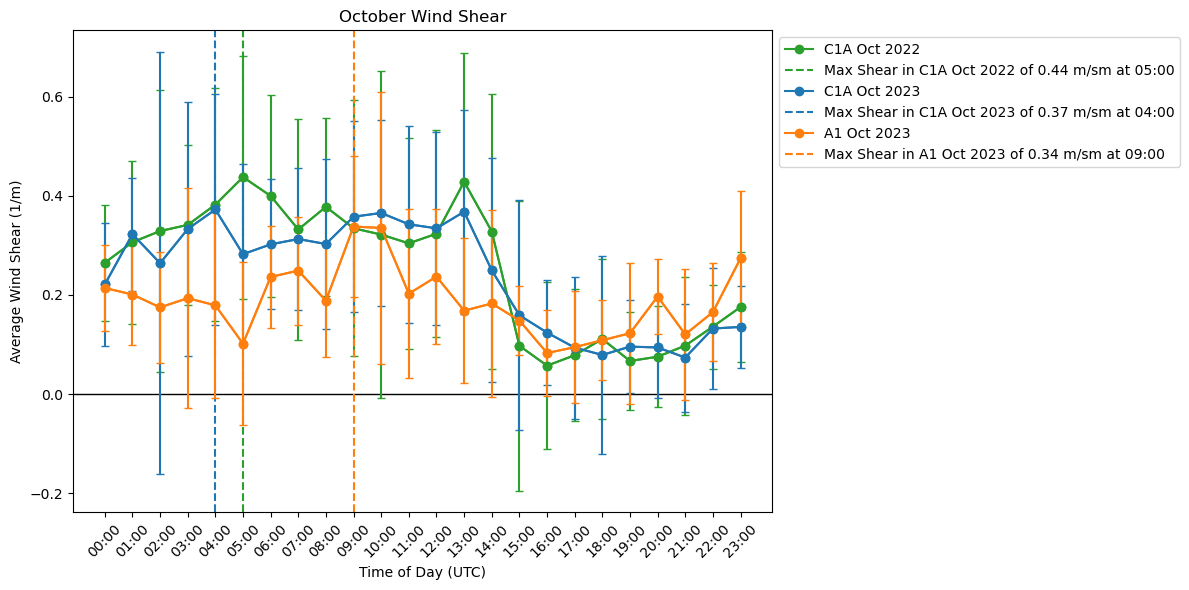

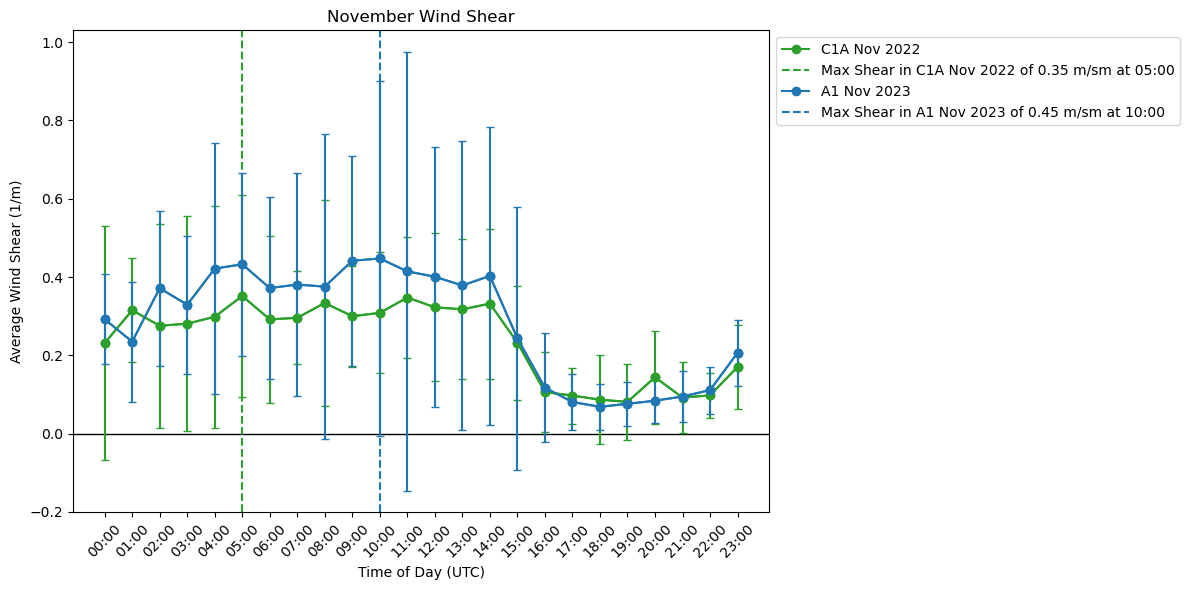

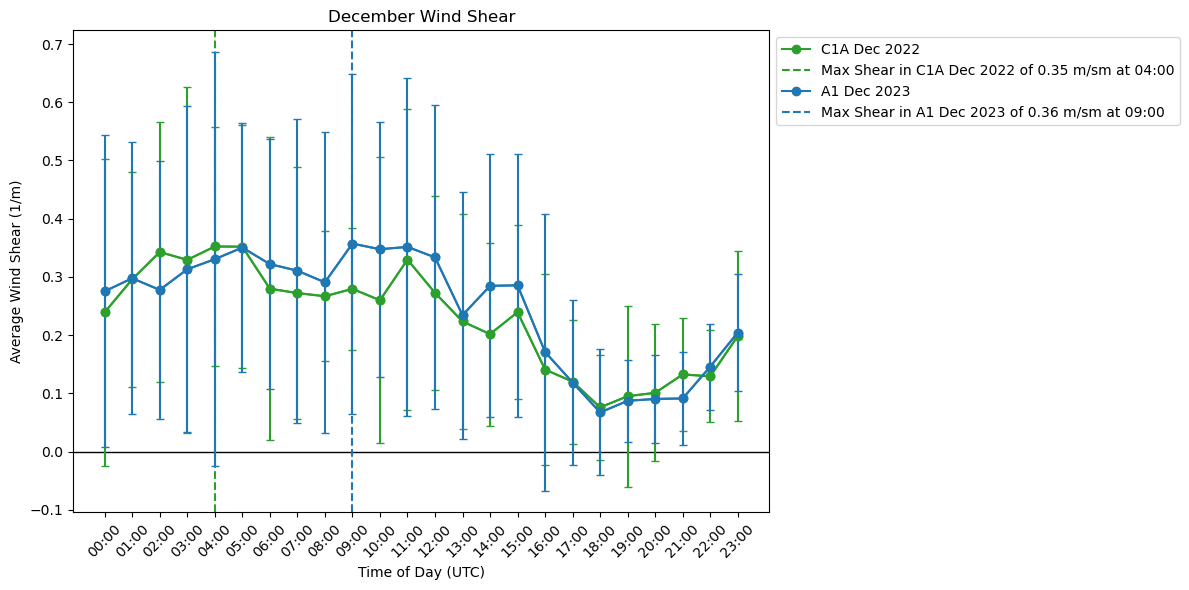

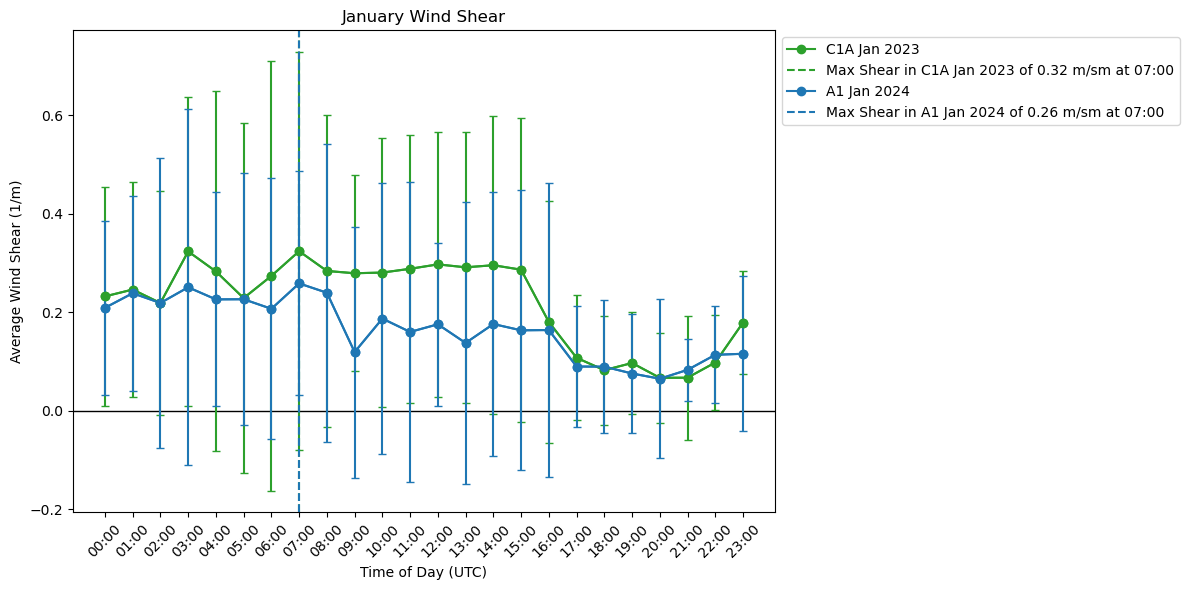

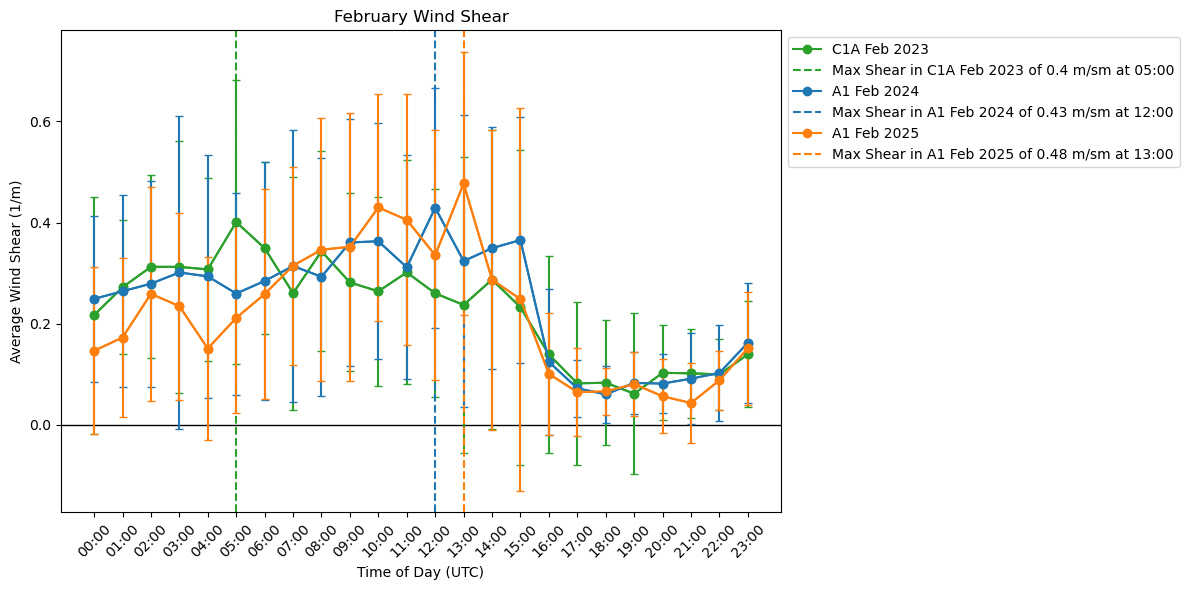

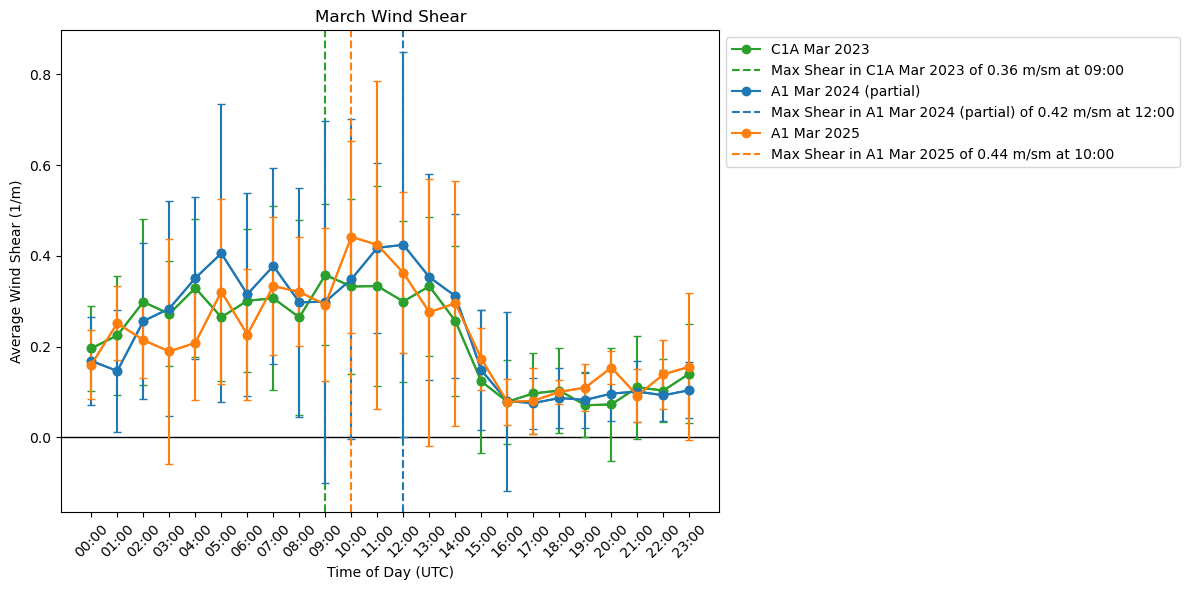

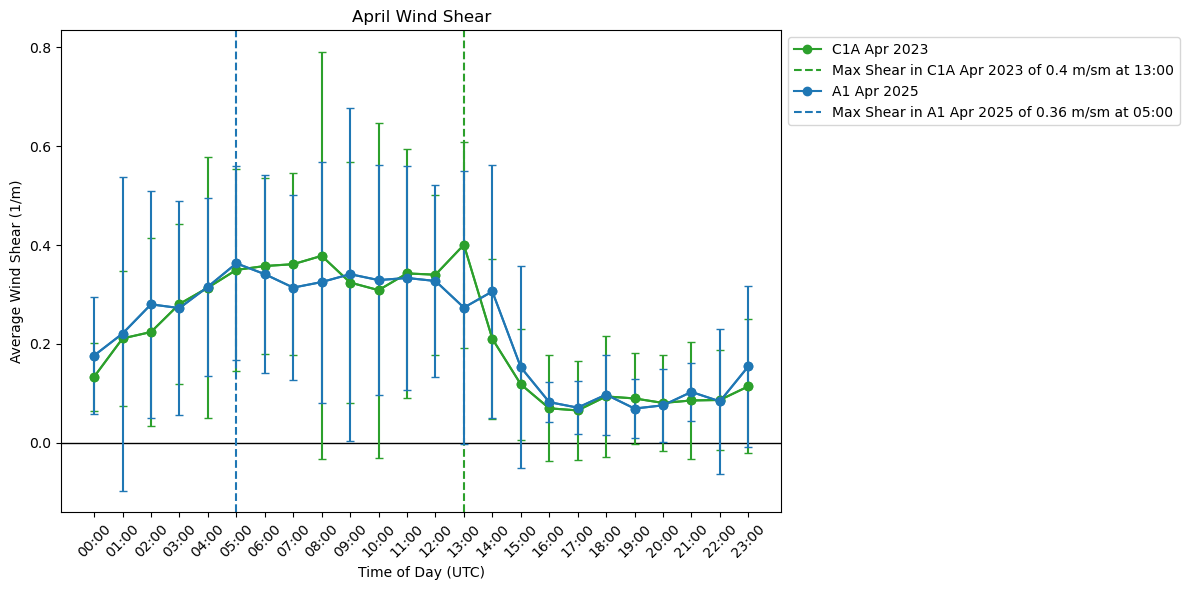

In [60]:
import pandas as pd

C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'
A1_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteA1_Data'

# October
C1A_202210_files = filter_files_by_date(C1A_directory, '20221001', '20221031')
C1A_times_shear_202210, C1A_wind_shear_202210 = calculate_wind_shear_with_alpha(C1A_202210_files)
C1A_avg_202210 = getDailyAvgWindShear(C1A_times_shear_202210, C1A_wind_shear_202210, pd.to_datetime('2022-10-01'), pd.to_datetime('2022-10-31'))

C1A_202310_files = filter_files_by_date(C1A_directory, '20231001', '20231031')
C1A_times_shear_202310, C1A_wind_shear_202310 = calculate_wind_shear_with_alpha(C1A_202310_files)
C1A_avg_202310 = getDailyAvgWindShear(C1A_times_shear_202310, C1A_wind_shear_202310, pd.to_datetime('2023-10-01'), pd.to_datetime('2023-10-31'))

A1_202310_files = filter_files_by_date(A1_directory, '20231001', '20231031')
A1_times_shear_202310, A1_wind_shear_202310 = calculate_wind_shear_with_alpha(A1_202310_files)
A1_avg_202310 = getDailyAvgWindShear(A1_times_shear_202310, A1_wind_shear_202310, pd.to_datetime('2023-10-01'), pd.to_datetime('2023-10-31'))

# November
C1A_202211_files = filter_files_by_date(C1A_directory, '20221101', '20221130')
C1A_times_shear_202211, C1A_wind_shear_202211 = calculate_wind_shear_with_alpha(C1A_202211_files)
C1A_avg_202211 = getDailyAvgWindShear(C1A_times_shear_202211, C1A_wind_shear_202211, pd.to_datetime('2022-11-01'), pd.to_datetime('2022-11-30'))

A1_202311_files = filter_files_by_date(A1_directory, '20231101', '20231130')
A1_times_shear_202311, A1_wind_shear_202311 = calculate_wind_shear_with_alpha(A1_202311_files)
A1_avg_202311 = getDailyAvgWindShear(A1_times_shear_202311, A1_wind_shear_202311, pd.to_datetime('2023-11-01'), pd.to_datetime('2023-11-30'))

# December
C1A_202212_files = filter_files_by_date(C1A_directory, '20221201', '20221231')
C1A_times_shear_202212, C1A_wind_shear_202212 = calculate_wind_shear_with_alpha(C1A_202212_files)
C1A_avg_202212 = getDailyAvgWindShear(C1A_times_shear_202212, C1A_wind_shear_202212, pd.to_datetime('2022-12-01'), pd.to_datetime('2022-12-31'))

A1_202312_files = filter_files_by_date(A1_directory, '20231201', '20231231')
A1_times_shear_202312, A1_wind_shear_202312 = calculate_wind_shear_with_alpha(A1_202312_files)
A1_avg_202312 = getDailyAvgWindShear(A1_times_shear_202312, A1_wind_shear_202312, pd.to_datetime('2023-12-01'), pd.to_datetime('2023-12-31'))

# January
C1A_202301_files = filter_files_by_date(C1A_directory, '20230101', '20230131')
C1A_times_shear_202301, C1A_wind_shear_202301 = calculate_wind_shear_with_alpha(C1A_202301_files)
C1A_avg_202301 = getDailyAvgWindShear(C1A_times_shear_202301, C1A_wind_shear_202301, pd.to_datetime('2023-01-01'), pd.to_datetime('2023-01-31'))

A1_202401_files = filter_files_by_date(A1_directory, '20240101', '20240131')
A1_times_shear_202401, A1_wind_shear_202401 = calculate_wind_shear_with_alpha(A1_202401_files)
A1_avg_202401 = getDailyAvgWindShear(A1_times_shear_202401, A1_wind_shear_202401, pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-31'))

# February
C1A_202302_files = filter_files_by_date(C1A_directory, '20230201', '20230228')
C1A_times_shear_202302, C1A_wind_shear_202302 = calculate_wind_shear_with_alpha(C1A_202302_files)
C1A_avg_202302 = getDailyAvgWindShear(C1A_times_shear_202302, C1A_wind_shear_202302, pd.to_datetime('2023-02-01'), pd.to_datetime('2023-02-28'))

A1_202402_files = filter_files_by_date(A1_directory, '20240201', '20240229')
A1_times_shear_202402, A1_wind_shear_202402 = calculate_wind_shear_with_alpha(A1_202402_files)
A1_avg_202402 = getDailyAvgWindShear(A1_times_shear_202402, A1_wind_shear_202402, pd.to_datetime('2024-02-01'), pd.to_datetime('2024-02-29'))

A1_202502_files = filter_files_by_date(A1_directory, '20250201', '20250228')
A1_times_shear_202502, A1_wind_shear_202502 = calculate_wind_shear_with_alpha(A1_202502_files)
A1_avg_202502 = getDailyAvgWindShear(A1_times_shear_202502, A1_wind_shear_202502, pd.to_datetime('2025-02-01'), pd.to_datetime('2025-02-28'))

# March
C1A_202303_files = filter_files_by_date(C1A_directory, '20230301', '20230331')
C1A_times_shear_202303, C1A_wind_shear_202303 = calculate_wind_shear_with_alpha(C1A_202303_files)
C1A_avg_202303 = getDailyAvgWindShear(C1A_times_shear_202303, C1A_wind_shear_202303, pd.to_datetime('2023-03-01'), pd.to_datetime('2023-03-31'))

A1_202403_files = filter_files_by_date(A1_directory, '20240301', '20240319')
A1_times_shear_202403, A1_wind_shear_202403 = calculate_wind_shear_with_alpha(A1_202403_files)
A1_avg_202403 = getDailyAvgWindShear(A1_times_shear_202403, A1_wind_shear_202403, pd.to_datetime('2024-03-01'), pd.to_datetime('2024-03-19'))

A1_202503_files = filter_files_by_date(A1_directory, '20250301', '20250331')
A1_times_shear_202503, A1_wind_shear_202503 = calculate_wind_shear_with_alpha(A1_202503_files)
A1_avg_202503 = getDailyAvgWindShear(A1_times_shear_202503, A1_wind_shear_202503, pd.to_datetime('2025-03-01'), pd.to_datetime('2025-03-31'))

# April
C1A_202304_files = filter_files_by_date(C1A_directory, '20230401', '20230430')
C1A_times_shear_202304, C1A_wind_shear_202304 = calculate_wind_shear_with_alpha(C1A_202304_files)
C1A_avg_202304 = getDailyAvgWindShear(C1A_times_shear_202304, C1A_wind_shear_202304, pd.to_datetime('2023-04-01'), pd.to_datetime('2023-04-30'))

A1_202504_files = filter_files_by_date(A1_directory, '20250401', '20250430')
A1_times_shear_202504, A1_wind_shear_202504 = calculate_wind_shear_with_alpha(A1_202504_files)
A1_avg_202504 = getDailyAvgWindShear(A1_times_shear_202504, A1_wind_shear_202504, pd.to_datetime('2025-04-01'), pd.to_datetime('2025-04-30'))

# Plotting
plotMultipleDataFrames([C1A_avg_202210, C1A_avg_202310, A1_avg_202310], labels=['C1A Oct 2022', 'C1A Oct 2023', 'A1 Oct 2023'], title="October Wind Shear", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (1/m)")
plotMultipleDataFrames([C1A_avg_202211, A1_avg_202311], labels=['C1A Nov 2022', 'A1 Nov 2023'], title="November Wind Shear", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (1/m)")
plotMultipleDataFrames([C1A_avg_202212, A1_avg_202312], labels=['C1A Dec 2022', 'A1 Dec 2023'], title="December Wind Shear", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (1/m)")
plotMultipleDataFrames([C1A_avg_202301, A1_avg_202401], labels=['C1A Jan 2023', 'A1 Jan 2024'], title="January Wind Shear", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (1/m)")
plotMultipleDataFrames([C1A_avg_202302, A1_avg_202402, A1_avg_202502], labels=['C1A Feb 2023', 'A1 Feb 2024', 'A1 Feb 2025'], title="February Wind Shear", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (1/m)")
plotMultipleDataFrames([C1A_avg_202303, A1_avg_202403, A1_avg_202503], labels=['C1A Mar 2023', 'A1 Mar 2024 (partial)', 'A1 Mar 2025'], title="March Wind Shear", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (1/m)")
plotMultipleDataFrames([C1A_avg_202304, A1_avg_202504], labels=['C1A Apr 2023', 'A1 Apr 2025'], title="April Wind Shear", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (1/m)")
